In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt

DEVICE = 'cuda'
SEED=14012024
torch.manual_seed(SEED)

In [2]:
class VAE_beta(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device='cpu'):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficient number of dimensions!"
        self.data_dim = data_dim
        self.device = device

        # Define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer_alpha = nn.Linear(hidden_dims[-1], data_dim)
        self.out_layer_beta = nn.Linear(hidden_dims[-1], data_dim)

        # Hidden layers for encoder
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])

        # Hidden layers for decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])

        # Initialize weights
        self.init_weights()

        self.to(device)

    def init_weights(self):
        # Initialize weights for the alpha and beta layers
        nn.init.xavier_uniform_(self.out_layer_alpha.weight)
        nn.init.xavier_uniform_(self.out_layer_beta.weight)

        # Initialize biases for alpha and beta layers
        nn.init.constant_(self.out_layer_alpha.bias, 1.0)
        nn.init.constant_(self.out_layer_beta.bias, 1.0)


    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        alpha = F.softplus(self.out_layer_alpha(h4))
        beta = F.softplus(self.out_layer_beta(h4))
        # Constrain alpha and beta to avoid extreme values
        alpha = torch.clamp(alpha, min=1e-4, max=3)
        beta = torch.clamp(beta, min=1e-4, max=20)

        return alpha, beta

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        alpha, beta = self.decode(z)
        return alpha, beta, mu, logvar

In [3]:
# lets use torch datasets with our data
class DatasetWrapper(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


mnist_train = np.loadtxt("/content/mnist_train.csv", delimiter=",", dtype=np.float32)
mnist_test = np.loadtxt("/content/mnist_test.csv", delimiter=",", dtype=np.float32)
train_labels = mnist_train[:,0]
train_data = mnist_train[:,1:] / 255.0
test_labels = mnist_test[:,0]
test_data = mnist_test[:,1:] / 255.0

train_data.shape, test_data.shape

train_ds = DatasetWrapper(train_data, train_labels)
test_ds = DatasetWrapper(test_data, test_labels)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=True)

import numpy as np

def transform_data(data, scale_factor=0.3, threshold=0.1, min_value=0.1):
    # Scale the pixel values
    #data = np.clip(data + scale_factor, 0, 1)

    # Apply thresholding
    data[data < threshold] = min_value

    return data

# Apply the transformation to your data
train_data_transformed = transform_data(train_data)
test_data_transformed = transform_data(test_data)

beta_train = DataLoader(DatasetWrapper(train_data_transformed, train_labels), batch_size = 256, shuffle=True)
beta_test = DataLoader(DatasetWrapper(test_data_transformed, test_labels), batch_size = 256, shuffle=True)

In [4]:
def train_beta(model: VAE_beta, epoch: int, train_loader: torch.utils.data.DataLoader, log_interval: int=25) -> list:
    model.train()
    train_loss = 0.
    train_loss_vals = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(model.device)
        optimizer.zero_grad()
        alpha, beta, mu, logvar = model(x)
        #print(f"Alpha mean: {alpha.mean()}, Beta mean: {beta.mean()}")
        loss_val, ce, kld = loss(alpha, beta, x, mu, logvar)
        loss_val.backward()
        train_loss += loss_val.item()
        train_loss_vals.append(loss_val.item())
        torch.nn.utils.clip_grad_norm_(model.parameters(), 15.0)
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train epoch={epoch} [{batch_idx*len(x)}/{len(train_loader.dataset)}]\t loss={loss_val.item() / len(x)}")
            print(f"BCE={ce} KLD={kld}")
    print(f"===> epoch={epoch} avrg.loss={train_loss/len(train_loader.dataset)}")
    return train_loss_vals

In [5]:
def test_beta(model: VAE_beta, epoch: int, test_loader: torch.utils.data.DataLoader) -> list:
    model.eval()
    test_loss = 0.
    test_loss_vals = []
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(model.device)
            alpha, beta, mu, logvar = model(x)
            test_loss_val, ce, kld = loss(alpha, beta, x, mu, logvar)
            test_loss += test_loss_val.item()
            test_loss_vals.append(test_loss_val.item())
            # if i == 0: # TODO: do we want to persist images here?
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([x[:n], ])
    test_loss /= len(test_loader.dataset)
    print(f"===> Test loss={test_loss}")
    return test_loss_vals

In [6]:
def beta_dist_neg_log_likelihood(alpha, beta, x):
    # Ensure alpha and beta are positive
    alpha = torch.clamp(alpha, min=1e-6)
    beta = torch.clamp(beta, min=1e-6)

    # Beta distribution
    beta_dist = torch.distributions.Beta(alpha, beta)

    # Negative log likelihood
    neg_log_likelihood = -beta_dist.log_prob(x)

    #print("Log prob min:", neg_log_likelihood.min().item(), "max:", neg_log_likelihood.max().item())

    return torch.sum(neg_log_likelihood)


In [7]:
#torch.autograd.set_detect_anomaly(True) # see where nan produced in code

EPOCHS=15

# 3.) modify the network architecture and try to obtain a better embedding
model_beta = VAE_beta(hidden_dims=[512, 256, 2, 256, 512]) # NOTE: 2D latent space
#model_beta.init_weights()

optimizer = optim.Adam(model_beta.parameters(), lr=1e-3)


def loss(alpha: torch.Tensor, beta: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    #assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    #BCE = neg_log_likelihood_cont_bernoulli(x.view(-1,784), recon_x)
    x_clamped = x.clamp(min=1e-4, max=1 - 1e-4)
    BCE = beta_dist_neg_log_likelihood(alpha, beta, x_clamped)
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #print(BCE, KLD)
    return BCE + KLD, BCE, KLD # = -ELBO


train_loss_vals_total = []
test_loss_vals_total = []
for e in range(1, EPOCHS+1):
    train_loss_vals = train_beta(model_beta, epoch=e, train_loader=train_loader)
    test_loss_vals = test_beta(model_beta, epoch=e, test_loader=test_loader)
    train_loss_vals_total.append(train_loss_vals)
    test_loss_vals_total.append(test_loss_vals)

Train epoch=1 [0/60000]	 loss=180.923583984375
BCE=46315.12890625 KLD=1.3103110790252686
Train epoch=1 [6400/60000]	 loss=-597.19091796875
BCE=-152980.546875 KLD=99.66849517822266
Train epoch=1 [12800/60000]	 loss=-781.9058837890625
BCE=-201126.71875 KLD=958.8126220703125
Train epoch=1 [19200/60000]	 loss=-814.6101684570312
BCE=-209211.25 KLD=671.046630859375
Train epoch=1 [25600/60000]	 loss=-805.51806640625
BCE=-206973.78125 KLD=761.1595458984375
Train epoch=1 [32000/60000]	 loss=-838.8215942382812
BCE=-215729.359375 KLD=991.0245971679688
Train epoch=1 [38400/60000]	 loss=-873.501953125
BCE=-224889.515625 KLD=1273.0216064453125
Train epoch=1 [44800/60000]	 loss=-880.8103637695312
BCE=-226625.953125 KLD=1138.504150390625
Train epoch=1 [51200/60000]	 loss=-880.657958984375
BCE=-226545.359375 KLD=1096.92919921875
Train epoch=1 [57600/60000]	 loss=-898.3050537109375
BCE=-231005.046875 KLD=1038.958740234375
===> epoch=1 avrg.loss=-780.2643553222656
===> Test loss=-897.9269454101562
Train 

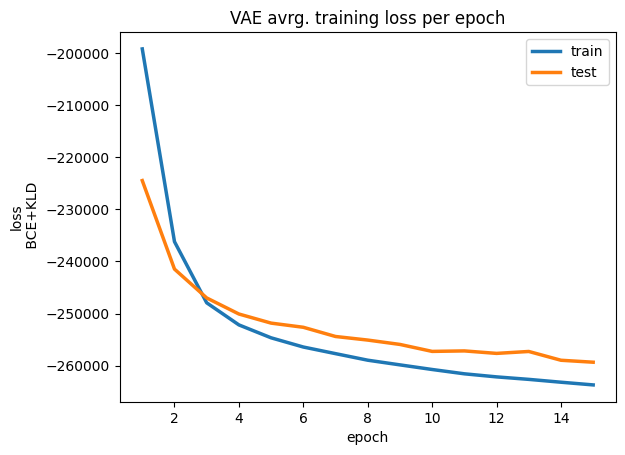

In [8]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()

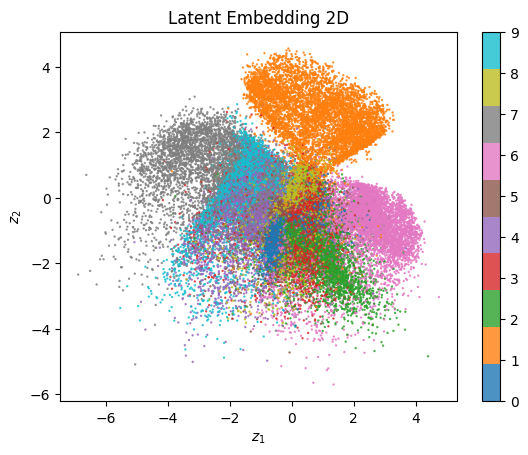

In [9]:
model_beta.to(DEVICE)
# encode entries
latent_coordinates = []
for data in train_data:
    # NOTE: we only obtain the mean for encoding and discard the log var
    latent_coordinates.append(model_beta.encode(torch.Tensor(data).to(DEVICE))[0].cpu().detach().numpy())
latent_coordinates = np.array(latent_coordinates)

# visualize 2D embedding of MNIST
plt.scatter(latent_coordinates[:,0], latent_coordinates[:,1], alpha=.8, s=0.5, c=train_labels, cmap="tab10")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.colorbar()
plt.title("Latent Embedding 2D")
plt.show()

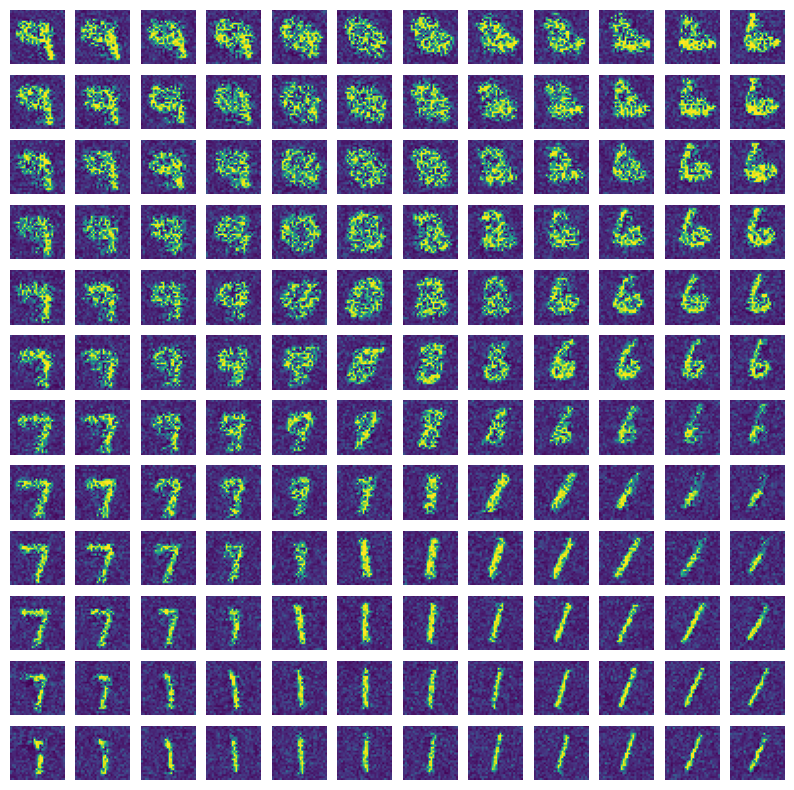

In [10]:
# Assuming the latent space is 2D
n = 12  # Number of images per dimension
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

plt.figure(figsize=(10, 10))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = torch.from_numpy(z_sample).float().to(DEVICE)

        # Decode the sample
        alpha, beta = model_beta.decode(z_sample)
        alpha, beta = alpha.cpu(), beta.cpu()

        # Sample from the Beta distribution
        beta_dist = torch.distributions.Beta(alpha, beta)
        decoded_sample = beta_dist.sample().detach().numpy()
        image = decoded_sample.reshape(28, 28)  # Assuming MNIST (28x28 images)

        plt.subplot(n, n, i * n + j + 1)
        plt.imshow(image)
        plt.axis('off')

plt.show()